In [1]:
from IPython.core.display import display, HTML
import sys
display(HTML("<style>.container { width:95% !important; }</style>"))
print(sys.version)

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
from datetime import date, datetime
import numpy as np
import pandas as pd
import dataframe_image as dfi
# pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()
sns.set_color_codes()
#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 20)

# column_names = ['# Seen', 'ALSA', '# Picked', 'ATA', '# GP', 'GP WR', '# OH', 'OH WR', '# GD', 'GD WR', '# GIH', 'GIH WR', '# GND', 'GND WR', 'IWD', 'Color', 'Rarity']

from Utilities import Logger
import WUBRG
from WUBRG import get_color_identity
from game_metadata import SETS, FORMATS
from game_metadata import Card,CardManager, SetMetadata, FormatMetadata
from data_fetching import DataLoader, LoadedData, DataFramer, FramedData, SetManager, CentralManager
from data_fetching.utils import get_next_17lands_update_time, get_prev_17lands_update_time, get_name_slice, get_color_slice, get_date_slice


LOAD_ALL = False
TRGT_SET = 'SNC'
LOG_LEVEL = Logger.FLG.DEFAULT
LOG_LEVEL

<Flags.DEFAULT: 3>

# Objects

In [3]:
import sys
try:
    del sys.modules["data_graphing"] 
    del data_graphing
except:
    pass

from data_graphing import ColorHandler, PlotterHelper, prettify_frame

In [4]:
class FramedDataFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._ARCH_FUNCS = ArchFuncs(self._DATA)
        self._SNGL_CARD_FUNCS = SingleCardFuncs(self._DATA)
    
    @property
    def SET(self):
        """The draft set."""
        return self._DATA.SET
    
    @property
    def FULL_SET(self):
        """The full name of the draft set."""
        return self._DATA.FULL_SET
    
    @property
    def FORMAT(self):
        """The format type."""
        return self._DATA.FORMAT
    
    @property
    def SHORT_FORMAT(self):
        """The shorthand of the format type."""
        return self._DATA.FULL_FORMAT
    
    @property
    def DATA(self):
        """The object which contains the data about the set and format."""
        return self._DATA
        
    def check_for_updates(self):
        """Populates and updates all data properties, filling in missing data."""
        self._DATA.check_for_updates()

    def reload_data(self):
        """Populates and updates all data properties, reloading all data."""
        self._DATA.reload_data()  
    
    def deck_group_frame(self, name=None, date=None, summary=False):
        """Returns a subset of the 'GROUPED_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_group_frame(name, date, summary)
     
    def deck_archetype_frame(self, deck_color=None, date=None, summary=False):
        """Returns a subset of the 'SINGLE_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_archetype_frame(deck_color, date, summary)
    
    def card_frame(self, name=None, deck_color=None, date=None, card_color=None, card_rarity=None, summary=False):
        """Returns a subset of the 'CARD' data as a DataFrame."""
        return self.DATA.card_frame(name, deck_color, date, card_color, card_rarity, summary)
    
    def compress_date_range_data(self, start_date, end_date, card_name=None):
        """Summarizes card data over a provided set of time."""
        return self.DATA.compress_date_range_data(start_date, end_date, card_name)
        
    
    #ArchFuncs
    def get_games_played(self, deck_color):
        return self._ARCH_FUNCS.get_games_played(deck_color)
        
    def get_avg_winrate(self, day=None, arch='All Decks'):
        return self._ARCH_FUNCS.get_avg_winrate(day, arch)
    
    def get_archetype_frame(self, colors, roll=None):
        return self._ARCH_FUNCS.get_archetype_frame(colors, roll)

    def get_archetype_winrate_history(self, color_filter=None, roll=None, *, save=False):
        return self._ARCH_FUNCS.get_archetype_winrate_history(color_filter, roll, save=save)

    def plot_archetype_winrate_history(self, color_filter=None, roll=None, color_dict=None, pref=''):
        return self._ARCH_FUNCS.plot_archetype_winrate_history(color_filter, roll, color_dict, pref)       
        
    def get_archetype_playrate_history(self, color_filter=None,  color_count=0, roll=None, *, save=False):
        return self._ARCH_FUNCS.get_archetype_playrate_history(color_filter, color_count, roll, save=save)

    def plot_archetype_playrate_history(self, color_filter=None, color_count=0, roll=None, color_dict=None, pref=''):
        return self._ARCH_FUNCS.plot_archetype_playrate_history(color_filter, color_count, roll, color_dict, pref)
    
    def card_relative_winrates(self, deck_colors, win_rate_col, filter_option=None):
        return self._ARCH_FUNCS.card_relative_winrates(deck_colors, win_rate_col, filter_option)
    
    #SingleCardFuncs
    def get_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.get_card_summary(card_name, colors, roll)

    def plot_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.plot_card_summary(card_name, colors, roll)
    
    def get_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.get_pick_stats(card_name, roll)
    
    def plot_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.plot_pick_stats(card_name, roll)
    
    def card_archetype_performance(self, card_name):
        return self._SNGL_CARD_FUNCS.card_archetype_performance(card_name)
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        return self._SNGL_CARD_FUNCS.stat_archetype_performance(stat_name, color_cols, min_colors, max_colors)

##    # filters = ['exact', 'subset', 'contains', 'adjascent'*]
##    ## TODO: Determine how to handle colourless cards.
##    ## 'exact': 'U' --> 'U'
##    ## 'subset': 'UW' --> 'U', 'W', 'WU'
##    ## 'contains': 'U' --> 'U', 'UW', 'UB', 'UR', 'UG'...
##    ## 'contains': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'superset': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'adjascent': 'UW' --> 'U', 'W', 'UW', 'UG', 'WG', 'UWG'...
##    def card_color_filter(frame, card_color=None, filter_style=''):
##        if card_color is None: 
##            return frame
##        
##            card_color = WUBRG.get_color_identity(card_color)
##            frame = frame[frame['Color'] == card_color]
##            return frame

    
    def compare_card_evaluations(self, start_date, end_date):
        def inner_func(date):
            df = self.card_frame(date=date, deck_color='')
            df.index = [tup[2] for tup in df.index]
            return df

        first = inner_func(date=start_date)
        last = inner_func(date=end_date)
        diff = last[['ALSA', 'ATA', 'Color', 'Rarity']].copy()
        diff['ALSA Change'] = first['ALSA'] - last['ALSA']
        diff['ATA Change'] = first['ATA'] - last['ATA']
        return diff[['ALSA', 'ALSA Change', 'ATA', 'ATA Change', 'Color', 'Rarity']]


    def get_top(self, column, count=10, asc=True, card_color=None, card_rarity=None, deck_color='', play_lim=None):
        frame = self.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
        frame = frame.sort_values(column, ascending=asc)

        if card_color is not None:
            card_color = WUBRG.get_color_identity(card_color)
            frame = frame[frame['Color'] == card_color]

        if play_lim is not None:
            #TODO: Fix this. 
            if type(play_lim) is float: play_lim *= self.get_games_played(deck_color)
            print(f'Minimum Games played to be included: {play_lim}')
            frame = frame[frame['# GP'] >= play_lim]

        return frame.head(count)

In [5]:
from data_graphing import ROLL, ARCHETYPES_COLOR_DICT
from WUBRG.consts import COLOR_PAIRS, COLOR_COUNT_REVERSE_MAP, COLOR_COUNT_SHORTHAND, COLOR_COUNT_SHORTHAND_MAP
from WUBRG import COLOUR_GROUPINGS

class ArchFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        
    @staticmethod
    def _get_play_stat_frame(frame, col, roll=None, aggfunc=None):
        if roll is None: roll = ROLL
        if aggfunc is None: aggfunc = np.sum
        ret = frame[[col]]
        ret.reset_index(inplace=True, level=1)
        ret = ret.pivot_table(values=col, index=ret.index, columns='Name', dropna=False, aggfunc=aggfunc)
        ret = ret.rolling(window=roll, min_periods=1, center=True).mean()
        ret.columns.names = [col]
        return ret

    def _get_all_stat(self, stat, roll=None, aggfunc=None):
        archetypes = self._get_play_stat_frame(self._DATA.deck_archetype_frame(), stat, roll, aggfunc)
        archetypes = archetypes[[color for color in COLOR_COMBINATIONS if color in archetypes.columns]]

        groups = self._get_play_stat_frame(self._DATA.deck_group_frame(), stat, roll, aggfunc)
        groups.rename(columns=COLOR_COUNT_SHORTHAND_MAP, inplace=True)
        groups = groups[COLOR_COUNT_SHORTHAND]

        return pd.concat([groups, archetypes], axis=1)


    def get_winrates(self, roll=None):
        wins = self._get_all_stat('Wins', roll, np.sum)
        games = self._get_all_stat('Games', roll, np.sum)
        frame = (wins / games) * 100
        frame.columns.names = ['Avg. Win %']
        return frame


    def get_playrates(self, num_colors=0, roll=None):
        games = self._get_all_stat('Games', roll, np.sum)
        
        if num_colors == 0:
            frame = games.div(games['ALL'], axis='rows') * 100
            frame.columns.names = ['% of Decks']
            return frame

        true_name = COLOR_COUNT_REVERSE_MAP[num_colors].title()
        summ_id = COLOR_COUNT_SHORTHAND_MAP[true_name]

        frame = games.div(games[summ_id], axis='rows') * 100
        frame.columns.names = [f'% of {num_colors}C Decks']
        return frame
   
    def get_archetype_winrate_history(self, color_filter=None, roll=None, *, save=False):
        if roll is None: roll = ROLL
            
        frame = self.get_winrates(roll)
       
        if isinstance(color_filter, str):
            # TODO: Make this more flexible.
            #col_filt = ['ALL', f'{len(color_filter)}C'] + [col for col in COLOR_PAIRS if color_filter in col]  
            col_filt = ['ALL', '2C'] + [col for col in COLOR_PAIRS if color_filter in col]  
            frame = frame[col_filt]
        elif isinstance(color_filter, list):
            frame = frame[color_filter]
            
        if save:
            PlotterHelper(self._DATA).frame_to_png(frame, "archetype_winrate_table.png")
        
        return frame        
        
    #TODO: Implement a more generic version of this that takes in a list of deck colours to include as output. 
    def get_archetype_playrate_history(self, color_filter=None, color_count=0, roll=None, *, save=False):
        if roll is None: roll = ROLL
            
        frame = self.get_playrates(color_count, roll)

        if isinstance(color_filter, str):
            col_filt = [col for col in COLOR_PAIRS if color_filter in col]
            frame = frame[col_filt]
        if isinstance(color_filter, list):
            frame = frame[color_filter]
            
        if save:
            PlotterHelper(self._DATA).frame_to_png(frame, "archetype_playrate_table.png")

        return frame
    
    def plot_archetype_winrate_history(self, color_filter=None, roll=None, color_dict=None, pref=''):
        if roll is None: roll = ROLL
        if color_dict is None: color_dict = ARCHETYPES_COLOR_DICT

        data = self.get_archetype_winrate_history(color_filter, roll)
        data.index = [idx[5:] for idx in data.index]
        colors = str(color_filter)  #TODO: Make this cleverer at showing filter.

        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_single_plot('Archetype Winrates', width=16, height=8)
        plot_help.accredit(y=0.035, x=0.51)
        plot_help.desc_note(colors=colors, roll=roll, y=0.935, x=0.51)
        
        plot_help.set_labels(x_label="Date", y_label="Win Rate")
        plot_help.set_data(data, color_filter)
        
        if not pref:
            plot_help.save_fig(f"win_rates_{roll}day_avg.png", "Metagame")
        else:
            plot_help.save_fig(f"{pref}_win_rates_{roll}day_avg.png", "Metagame")

    def plot_archetype_playrate_history(self, color_filter=None, color_count=0, roll=None, color_dict=None, pref=''):
        if roll is None: roll = ROLL
        if color_dict is None: color_dict = ARCHETYPES_COLOR_DICT
            
        data = self.get_archetype_playrate_history(color_filter, color_count, roll)
        data.index = [idx[5:] for idx in data.index]
        
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_single_plot('Archetype Playrates', width=16, height=8)
        plot_help.accredit(y=0.035, x=0.51)
        plot_help.desc_note(colors=color_filter, roll=roll, y=0.935, x=0.51)
        
        plot_help.set_labels(x_label="Date", y_label="Percent of Metagame")
        plot_help.set_data(data, color_filter)
        
        if not pref:
            plot_help.save_fig(f"play_rates_{roll}day_avg.png", "Metagame")
        else:
            plot_help.save_fig(f"{pref}_play_rates_{roll}day_avg.png", "Metagame")
            
    
    def card_relative_winrates(self, deck_colors=None, win_rate_col='GIH WR', filter_option=None):
        deck_colors = get_color_identity(deck_colors)
        
        # Get the relevant list of cards, and then trim it down to the relevant colours.
        sub_frame = self._DATA.card_frame(deck_color=deck_colors)
        sub_frame = set_data.BO1.DATA.CARD_HISTORY_FRAME.loc[slice(None), get_color_slice(deck_colors), get_name_slice(None)]
        sub_frame = sub_frame.reset_index(level=1)
        if deck_colors:
            sub_frame = sub_frame[sub_frame['Cast Color'].isin(WUBRG.get_color_subsets(deck_colors))]

        # Get the winrates for the cards and average winrate of the archetype, then re-center the card winrates with it. 
        win_frame = self._get_play_stat_frame(sub_frame, win_rate_col, roll=1, aggfunc=np.mean)
        avg_frame = self.get_archetype_winrate_history(deck_colors)
        target_avg = deck_colors if deck_colors else 'ALL'
        ret_frame = win_frame.sub(avg_frame[target_avg], axis='rows').T

        # Get the games played from the subset of cards and use it to re-weight the win rates per day, to calculate an accurate average.
        games_frame = self._get_play_stat_frame(sub_frame, '# GP', roll=1, aggfunc=np.mean).T
        ret_frame[f'AVG'] = (ret_frame * games_frame).sum(axis=1) / games_frame.sum(axis=1)
        ret_frame['# GP'] = games_frame.sum(axis=1)

        # Sort by most winning first.
        ret_frame = ret_frame.sort_values(f'AVG', ascending=False).T
        return ret_frame[::-1]

In [6]:
from data_graphing import ROLL, STATS_COLOR_DICT
from WUBRG import COLOR_COMBINATIONS
from WUBRG.consts import COLOR_PAIRS


class SingleCardFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._COLOR_IDX = 0
        
    def _shorten_data(self, card_name, roll, cols, colors=''):
        frame = self._DATA.card_frame(name=card_name, deck_color=colors)[cols]
        frame.index = [tup[0][5:] for tup in frame.index]
        rolling = frame.rolling(window=roll, min_periods=1, center=True).mean()
        return rolling

    def plot_card_summary(self, card_name, colors='', roll=None, color_dict=None):
        if roll is None: roll = ROLL
        if color_dict is None: color_dict = STATS_COLOR_DICT
        rolling = self._shorten_data(card_name, roll, ['GIH WR', 'GND WR', 'ATA', 'ALSA', '# GP', '# GIH', '# Picked', '# Seen'], colors=colors)
        if rolling.empty:
            print(f"""Could not find data for "{card_name}". Please make sure it is spelled correctly, or you are accessing the right set.""")
            return
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_quad_plot(card_name)
        plot_help.accredit(y=0.075)
        plot_help.desc_note(colors=colors, roll=roll)
                
        plot_help.set_labels(y_label="Win Percent", g_x=0, g_y=0)
        plot_help.set_data(rolling, ['GIH WR', 'GND WR'], g_x=0, g_y=0)
        
        plot_help.set_labels(y_label="Pick Number", g_x=0, g_y=1)
        plot_help.set_data(rolling, ['ALSA', 'ATA'], inv_y=True, g_x=0, g_y=1)
        
        plot_help.set_labels(x_label="Date", y_label="# of Games", g_x=1, g_y=0)
        plot_help.set_data(rolling, ['# GP', '# GIH'], g_x=1, g_y=0)

        plot_help.set_labels(x_label="Date", y_label="# of Cards", g_x=1, g_y=1)
        plot_help.set_data(rolling, ['# Seen', '# Picked'], g_x=1, g_y=1)
        
        if colors:
            plot_help.save_fig(f"pcs_{card_name}_{colors}.png", "Summary")
        else:
            plot_help.save_fig(f"pcs_{card_name}.png", "Summary")
    
    
    def plot_pick_stats(self, card_name, roll=None, color_dict=None):
        if roll is None: roll = ROLL        
        if color_dict is None: color_dict = STATS_COLOR_DICT
        taken_data = self._shorten_data(card_name, roll, ['ALSA', 'ATA'])
        if taken_data.empty:
            print(f"""Could not find data for "{card_name}". Please make sure it is spelled correctly, or you are accessing the right set.""")
            return
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_single_plot(card_name)
        plot_help.accredit()
        plot_help.desc_note(roll=roll, y=0.96)
        
        plot_help.set_labels(x_label="Date", y_label="Pick Number")
        plot_help.set_data(taken_data, ['ALSA', 'ATA'], inv_y=True)
        
        plot_help.save_fig(f"pps_{card_name}.png", "Pick Stats")


    def card_archetype_performance(self, card_name):
        d = dict()
        d['AVG'] = self._DATA.card_frame(card_name, '', summary=True)
        for col in COLOR_PAIRS:
            d[col] = self._DATA.card_frame(card_name, col, summary=True)

        test_frame = pd.DataFrame.from_dict(d).T
        return test_frame
    
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        series = self._DATA.card_frame(summary=True)[stat_name]
        frame = series.reset_index(level=0)
        ret = pd.pivot_table(frame, index='Name', columns='Deck Colors')
        ret.columns = ret.columns.droplevel(0)
        #ret = ret[COLOR_COMBINATIONS]  #Re-orders the columns in WUBRG order
        if color_cols is not None:
            ret = ret[color_cols]
        return ret

# Initialization

In [7]:
data_manager = None
set_data = None

In [8]:
print(f"Current Local Time:  {datetime.now()}")
print(f"Last 17Lands Update: {get_prev_17lands_update_time()}")
print(f"Current UTC Time:    {datetime.utcnow()}")
print(f"Next 17Lands Update: {get_next_17lands_update_time()}")

Current Local Time:  2022-05-09 11:27:01.558576
Last 17Lands Update: 2022-05-09 02:00:00
Current UTC Time:    2022-05-09 13:57:01.558576
Next 17Lands Update: 2022-05-10 02:00:00


In [9]:
start = datetime.utcnow()

if LOAD_ALL:
    if data_manager is None:
        data_manager = CentralManager()
        SNC = data_manager['SNC']
        NEO = data_manager['NEO']
        VOW = data_manager['VOW']
        MID = data_manager['MID']
        set_data = data_manager[TRGT_SET]
            
    data_manager.check_for_updates()
else:
    if set_data is None:
        set_data = SetManager(TRGT_SET)
    set_data.check_for_updates()

examiner = FramedDataFuncs(set_data.BO1)

end = datetime.utcnow()
print(f"\n --- Data loaded in {end - start}.")

Loading set metadata for: SNC
Fetching data for set: SNC
Fetching card data for set: SNC
Done!

Checking for missing data for SNC PremierDraft...
Getting overall data for SNC PremierDraft
Getting data for SNC PremierDraft, date: 2022-04-28
Getting data for SNC PremierDraft, date: 2022-04-29
Getting data for SNC PremierDraft, date: 2022-04-30
Getting data for SNC PremierDraft, date: 2022-05-01
Getting data for SNC PremierDraft, date: 2022-05-02
Getting data for SNC PremierDraft, date: 2022-05-03
Getting data for SNC PremierDraft, date: 2022-05-04
Getting data for SNC PremierDraft, date: 2022-05-05
Getting data for SNC PremierDraft, date: 2022-05-06
Getting data for SNC PremierDraft, date: 2022-05-07
Getting data for SNC PremierDraft, date: 2022-05-08
Finished checking for missing data for SNC PremierDraft.

Checking for missing data for SNC TradDraft...
Getting overall data for SNC TradDraft
Getting data for SNC TradDraft, date: 2022-04-28
Getting data for SNC TradDraft, date: 2022-04-2

In [10]:
examiner = FramedDataFuncs(set_data.BO1)
rel_wins_frame = examiner.card_relative_winrates('WR', 'GIH WR')
prettify_frame(rel_wins_frame)

GIH WR,Elspeth Resplendent,Patch Up,Scuttling Butler,Brokers Initiate,Halo Scarab,Brass Knuckles,Tramway Station,Sanctuary Warden,Jetmir's Garden,Swooping Protector,Mysterious Limousine,Ominous Parcel,Unlucky Witness,Paragon of Modernity,Revelation of Power,Rabble Rousing,Knockout Blow,Inspiring Overseer,"Jaxis, the Troublemaker",Professional Face-Breaker,Kill Shot,Mage's Attendant,Arc Spitter,Maestros Theater,Gathering Throng,Call In a Professional,Gilded Pinions,Hold for Ransom,Wrecking Crew,Exhibition Magician,Ready to Rumble,Strangle,Pyre-Sledge Arsonist,Halo Fountain,Pugnacious Pugilist,Sizzling Soloist,Citizen's Crowbar,Speakeasy Server,Sky Crier,Cabaretti Courtyard,Witty Roastmaster,Plasma Jockey,Mayhem Patrol,Raffine's Informant,Torch Breath,Sticky Fingers,Involuntary Employment,Buy Your Silence,Riveteers Requisitioner,Racers' Ring,Botanical Plaza,Rumor Gatherer,Dapper Shieldmate,Boon of Safety,Celebrity Fencer,Devilish Valet,Quick-Draw Dagger,Angelic Observer,Backup Agent,Unlicensed Hearse,Antagonize,Depopulate,Riveteers Initiate,Light 'Em Up,Chrome Cat,Illuminator Virtuoso,Big Score,Extraction Specialist,"Urabrask, Heretic Praetor",Hoard Hauler,Obscura Storefront,Rob the Archives,Ballroom Brawlers,Goldhound,Ziatora's Proving Ground,Daring Escape,Refuse to Yield,Skybridge Towers,Jackhammer,Raffine's Guidance,Brokers Hideout,Cement Shoes,"Giada, Font of Hope",Getaway Car,Riveteers Overlook,Glittering Stockpile,Suspicious Bookcase,Spara's Headquarters,Raffine's Tower,Xander's Lounge,Arcane Bombardment,"Luxior, Giada's Gift",Structural Assault,Waterfront District,Widespread Thieving
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
# GP,23.00,48.00,16.00,19.00,175.00,7.00,56.00,55.00,34.00,239.00,73.00,46.00,178.00,79.00,290.00,144.00,200.00,756.00,121.00,93.00,183.00,277.00,23.00,33.00,535.00,339.00,78.00,484.00,278.00,750.00,230.00,686.00,88.00,31.00,294.00,392.00,300.00,376.00,494.00,380.00,866.00,864.00,1018.00,722.00,107.00,544.00,96.00,202.00,297.00,179.00,160.00,248.00,372.00,274.00,266.00,53.00,335.00,67.00,665.00,57.00,510.00,18.00,199.00,501.00,127.00,412.00,196.00,102.00,85.00,21.00,28.00,63.00,153.00,509.00,8.00,113.00,64.00,20.00,67.00,226.00,103.00,25.00,24.00,11.00,79.00,10.00,4.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
AVG,16.38,13.37,12.13,12.07,11.10,11.04,10.46,9.20,8.41,7.55,7.06,6.99,6.92,6.40,6.27,5.90,5.51,5.46,5.10,4.65,4.48,4.47,4.43,4.16,3.66,3.30,2.97,2.38,2.12,1.99,1.93,1.88,1.63,1.40,1.07,0.98,0.83,-0.52,-0.55,-0.61,-0.99,-1.24,-1.66,-1.72,-1.98,-2.16,-2.47,-2.53,-2.85,-3.09,-3.10,-4.03,-4.15,-4.16,-4.17,-4.30,-4.49,-4.53,-4.95,-5.07,-5.08,-5.28,-5.35,-5.71,-5.87,-6.17,-6.35,-6.38,-6.53,-7.10,-7.55,-8.08,-8.11,-8.16,-8.33,-9.33,-11.20,-11.67,-11.87,-11.99,-19.81,-20.42,-20.89,-21.04,-21.48,-22.69,-23.37,-54.17,-57.93,-57.93,---,---,---,---,---
2022-05-08,-53.66,---,---,---,21.34,---,---,-3.66,---,-3.66,-3.66,21.34,-28.66,46.34,4.24,13.01,13.01,-6.04,-53.66,-53.66,-28.66,17.77,---,---,19.67,-8.20,46.34,-1.48,21.34,-17.29,---,26.34,-20.33,---,-8.20,-35.48,29.67,-3.66,6.34,13.01,0.89,-3.66,6.34,-14.53,---,-7.83,21.34,46.34,-20.33,-20.33,46.34,16.34,16.34,-16.16,-3.66,-53.66,8.84,---,1.51,---,-3.66,---,-7.50,-14.77,-10.80,-1.48,-3.66,-3.66,3.48,---,---,---,-20.33,-11.55,---,-53.66,17.77,---,---,-16.16,-53.66,-53.66,---,---,---,---,---,---,---,---,---,---,---,---,---
2022-05-07,-2.38,---,---,---,-2.38,---,---,---,14.29,-19.05,47.62,47.62,19.62,---,-16.02,22.62,47.62,5.20,7.62,-7.94,47.62,-2.38,---,7.62,0.12,10.12,-52.38,14.29,-6.23,6.59,-16.02,-13.25,14.29,-19.05,-2.38,10.78,-14.88,-6.93,-19.05,-0.66,0.00,9.62,5.25,11.91,7.62,18.21,-6.93,14.29,33.33,-2.38,-52.38,-16.02,11.26,-6.23,14.29,-19.05,5.51,-52.38,-4.55,7.62,-2.38,14.29,-2.38,14.29,47.62,2.16,-25.11,-14.88,-52.38,-19.05,---,-12.38,19.05,-6.55,---,14.29,14.29,---,-52.38,22.62,33.33,-12.38,-27.38,---,-52.38,---,---,---,---,---,---,---,---,---,---
2022-05-06,15.28,15.28,---,---,1.95,---,-26.3

In [11]:
raise Exception('Stopping Auto-Run!')

Exception: Stopping Auto-Run!

# Examine Data

In [ ]:
examiner.plot_card_summary('Girder Goons')

In [ ]:
examiner.plot_pick_stats('Girder Goons')

In [ ]:
examiner.card_archetype_performance('Girder Goons')

In [ ]:
examiner.stat_archetype_performance('GIH WR', color_cols=['WU', 'WG', 'UB', 'BR', 'RG'])

In [ ]:
examiner = FramedDataFuncs(set_data.BO1)
rel_wins_frame = examiner.card_relative_winrates('WR', 'GIH WR')
rel_wins_fra

In [ ]:
games = rel_wins_frame.loc['# GP']
def format_rel_wins(v):
    if v == '---':
        return '---'
    elif v > 0:
        return f"+{round(v, 2)}%"
    else:
        return f"-{round(v, 2)}%"
rel_wins_frame = examiner.card_relative_winrates('WR', 'GIH WR')
rel_wins_frame.fillna('---', inplace=True)
prettify_frame(rel_wins_frame.style.format(format_rel_wins))

In [90]:
examiner._DATA.card_frame(deck_color='')

ALSA     ATA
Date       Deck Colors Name                                   
2022-04-28             Angelic Observer          4.789   6.531
                       Backup Agent              5.346   7.714
                       Ballroom Brawlers         3.605   4.139
                       Boon of Safety            6.952  10.440
                       Brokers Initiate          7.150  10.781
...                                                ...     ...
2022-05-08             Spara's Headquarters      2.069   2.154
                       Tramway Station           5.475   7.567
                       Waterfront District       5.206   7.411
                       Xander's Lounge           2.345   2.831
                       Ziatora's Proving Ground  2.392   2.816

[2871 rows x 2 columns]

## Current Tests

TODO: Update code so that
 1) Cards without data aren't treated as having a 0% win rate.
 2) Ensure that NaNs are respected so the average improvement is calculated properly.

In [100]:
sub_frame = set_data.BO1.DATA.CARD_HISTORY_FRAME.loc[slice('2022-04-28', '2022-05-01'), get_color_slice('WR'), get_name_slice(None)]
sub_frame.reset_index(level=1, inplace=True)
sub_frame = sub_frame[sub_frame['Cast Color'].isin(WUBRG.get_color_subsets('WR'))]
sub_frame

SyntaxError: invalid syntax (Temp/ipykernel_19096/1076373444.py, line 1)

In [77]:
sub_frame.loc[(slice(None), slice('Depopulate', 'Depopulate', None)), :]

NameError: name 'sub_frame' is not defined

In [ ]:
temp_frame = sub_frame.copy()
temp_frame.reset_index(inplace=True, level=1)
#temp_frame

In [ ]:
temp_frame.pivot_table(values='GIH WR', index=temp_frame.index, columns='Name', dropna=False)

In [ ]:
# Get the winrates and average winrate of the colour group, then re-center the card winrates with it. 
win_frame = ArchFuncs._get_play_stat_frame(sub_frame, 'GIH WR', roll=1)
win_frame

In [ ]:
TRG_DECK_COLOR = 'WR'
TRG_WIN_RATE = 'GIH WR'

def card_relative_winrates(deck_colors, win_rate_col, filter_option=None):
    # Get the relevant list of cards, and then trim it down to the relevant colours.
    sub_frame = set_data.BO1.DATA.CARD_HISTORY_FRAME.loc[slice(None), get_color_slice(deck_colors), get_name_slice(None)]
    sub_frame = sub_frame.reset_index(level=1)
    sub_frame = sub_frame[sub_frame['Cast Color'].isin(WUBRG.get_color_subsets(deck_colors))]

    # Get the winrates and average winrate of the colour group, then re-center the card winrates with it. 
    win_frame = ArchFuncs._get_play_stat_frame(sub_frame, win_rate_col, roll=1, aggfunc=np.mean)
    avg_frame = examiner.get_archetype_winrate_history([deck_colors])
    centred_frame = win_frame.sub(avg_frame[deck_colors], axis='rows').T

    # Get the games played from the subset of cards and use it to re-weight the win rates per day, to calculate an accurate average.
    games_frame = ArchFuncs._get_play_stat_frame(sub_frame, '# GP', roll=1, aggfunc=np.mean).T
    ret_frame = centred_frame
    ret_frame['AVG'] = (ret_frame * games_frame).sum(axis=1) / games_frame.sum(axis=1)
    ret_frame['GAMES'] = games_frame.sum(axis=1)

    # Sort by most winning first.
    ret_frame = ret_frame.sort_values('AVG', ascending=False).T
    return sub_frame, win_frame, games_frame, avg_frame, ret_frame, centred_frame
    
frames = card_relative_winrates(TRG_DECK_COLOR, TRG_WIN_RATE)
frames[4]

In [ ]:
def gt(x, y):  #Used for function pointer shenanigans
    return x > y

def lt(x, y):  #Used for function pointer shenanigans
    return x < y

def filter_quadrant_cards_df(func1, func2, iwd_thresh=0, play_lim=0.01, card_rarity=None, deck_color=''):
    frame = set_data.BO1.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
    
    # TODO: Make the mean different based on card rarity so cards aren't moved into incorrect categories.
    
    if play_lim is not None:
        if type(play_lim) is float: play_lim *= set_data.BO1.get_games_played(deck_color)
        print(f'Minimum Games played to be included: {play_lim}')
        frame = frame[frame['# GP'] >= play_lim]
        
    games_played_mean = frame['# GP'].mean()
    cards = frame[func1(frame['IWD'], iwd_thresh)]
    cards = cards[func2(cards['# GP'], games_played_mean)]
    cards = cards.sort_values('IWD', ascending=func1==lt)
    return cards


def get_trap_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_niche_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_staple_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_dreg_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

In [ ]:
get_niche_cards(deck_color='GW', card_rarity='CU')

In [69]:
import functools

@functools.singledispatch
def _stringify_for_date_slice(arg):
    # By default, if we don't have a special way to handle a parameter, don't change it.
    return arg

@_stringify_for_date_slice.register(date)
def _stringify_for_date_slice_date(arg):
    # Convert the date into a string, then handle that.
    return _stringify_for_date_slice(str(arg))  


@_stringify_for_date_slice.register(datetime)
def _stringify_for_date_slice_datetime(arg):
    # Isolate the date from the datetime, then handle that.
    return _stringify_for_date_slice_date(arg.date())


@functools.singledispatch
def get_date_slice(arg):
    # By default, if we don't have a special way to handle a parameter, don't change it.
    return arg

@get_date_slice.register(type(None))
def _get_date_slice_none(val):
    # If the parameter is a None, marshall it into a slice.
    return slice(val)

@get_date_slice.register(str)
@get_date_slice.register(date)
@get_date_slice.register(datetime)
def _get_date_slice_string(val):
    # If the parameter is a string, date or datetime, stringify it and marshall it into a single element list to filter properly.
    return [_stringify_for_date_slice(val)]

# TODO: Handle how to parse iterable types.
@get_date_slice.register(list)
@get_date_slice.register(dict)
@get_date_slice.register(set)
def _get_date_slice_iterable(val):
    # If the parameter is iterable, fsttempt to convert all of its elements, and return them as a list.
    return [_stringify_for_date_slice(str_date) for str_date in val]


@get_date_slice.register(tuple)
def _get_date_slice_range(val):
    # If the parameter is iterable, check if it should be a range.
    if len(val) == 2:
        # If it should be a range, get the colours check that the colours elements are properly ordered.
        str_date1 = _stringify_for_date_slice(val[0])
        str_date2 = _stringify_for_date_slice(val[1])
        return slice(str_date1, str_date2)
        
        # TODO: Check date ordering
        # Then make sure a valid range is returned.
        if color_compare(col2, col1) == 1:
            return slice(col1, col2)
        else:
            # TODO: See if returning a reversed range is possible.
            return slice(col2, col1)
    else:
        # If not, handle it like as an iterable.
        return _get_date_slice_iterable(val)

In [70]:
get_date_slice(None)

slice(None, None, None)

In [71]:
get_date_slice('2022-05-09')

['2022-05-09']

In [74]:
get_date_slice(date(2022, 5, 9))

['2022-05-09']

In [76]:
get_date_slice(datetime(2022, 5, 9, 5, 6))

['2022-05-09']

In [ ]:
set_data.BO1.DATA.SINGLE_ARCHETYPE_SUMMARY_FRAME.loc[['W']]

In [ ]:
from data_fetching.utils.index_slice_helper import get_name_slice, get_color_slice

In [ ]:
set_data.BO1.DATA.CARD_HISTORY_FRAME.loc[slice('2022-04-29', '2022-05-01'), get_color_slice(''), get_name_slice({'Girder Goons', 'Angelic Observer', 'A Little Chat', 'Case the Joint'})]

In [ ]:
data = set_data.BO1.DATA.CARD_HISTORY_FRAME.loc(axis=0)[pd.IndexSlice[slice(None), get_color_slice(''), get_name_slice(None)]]
cheap = data[data['CMC'] <= 3]
expensive = data[data['CMC'] >= 5]

In [ ]:
cheap['Games Won'] = cheap['# GIH'] * cheap['GIH WR'] * 0.01
cheap_sums = cheap[['# GP', '# GIH', 'Games Won']].sum()
cheap_wr = cheap_sums['Games Won'] / cheap_sums['# GIH']
cheap_wr

In [ ]:
expensive['Games Won'] = expensive['# GIH'] * expensive['GIH WR'] * 0.01
expensive_sums = expensive[['# GP', '# GIH', 'Games Won']].sum()
expensive_wr = expensive_sums['Games Won'] / expensive_sums['# GIH']
expensive_wr

In [ ]:
for i in range(0, 9):
    by_cmc = data[data['CMC'] == i]
    by_cmc['Games Won'] = by_cmc['# GIH'] * by_cmc['GIH WR'] * 0.01
    sums = by_cmc[['# GP', '# GIH', 'Games Won']].sum()
    avg = by_cmc[['GIH WR']].mean()['GIH WR']
    wr = sums['Games Won'] / sums['# GIH'] * 100
    print(f"CMC: {i}, WR: {wr}  AVG: {avg}")

In [18]:
examiner.get_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'])

% of Decks,2C,3C,WU,WG,UB,BR,RG,WUB,WUG,UBR,BRG,WRG
Date,,,,,,,,,,,,
2022-04-28,25.230452,68.962613,4.644144,4.190258,2.973656,9.466099,2.983014,13.817790,16.386692,13.031678,12.734547,12.549717
2022-04-29,25.086934,69.349270,5.455361,4.388469,2.754478,8.532649,3.032418,13.756185,17.654830,12.560916,12.322860,12.663119
2022-04-30,25.452751,69.169064,6.208194,4.732061,2.739703,8.014981,2.818149,13.949035,18.767977,12.308419,11.586379,12.209729
2022-05-01,26.668233,68.358838,7.425880,5.264532,2.741073,7.450253,2.865549,13.722776,20.289514,11.764245,10.777145,11.506589
2022-05-02,28.215813,67.144772,8.596778,5.706262,3.018173,7.281000,2.660734,13.548040,21.088001,11.432584,9.856021,10.935634
2022-05-03,29.865888,65.808181,9.512443,6.074311,3.267481,7.146372,2.926181,13.161008,21.471571,11.252447,9.217207,10.428510
2022-05-04,31.133581,64.797884,10.674631,6.217369,3.519072,6.923007,2.821413,12.716308,21.965983,11.173936,8.659173,10.055630
2022-05-05,32.620703,63.570264,11.398952,6.610688,3.773850,6.963681,2.791101,12.522428,22.840121,11.055341,7.903039,9.015961
2022-05-06,33.733361,62.728464,12.044509,7.106237,3.887624,6.931513,2.594432,12.110031,23.378624,10.958227,7.425799,8.610939


In [20]:
examiner.get_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG']).diff()

% of Decks,2C,3C,WU,WG,UB,BR,RG,WUB,WUG,UBR,BRG,WRG
Date,,,,,,,,,,,,
2022-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-29,-0.143518,0.386657,0.811217,0.198211,-0.219178,-0.933450,0.049404,-0.061605,1.268138,-0.470762,-0.411687,0.113402
2022-04-30,0.365817,-0.180207,0.752833,0.343592,-0.014775,-0.517668,-0.214269,0.192850,1.113147,-0.252497,-0.736481,-0.453390
2022-05-01,1.215482,-0.810226,1.217687,0.532472,0.001371,-0.564727,0.047400,-0.226259,1.521537,-0.544174,-0.809234,-0.703140
2022-05-02,1.547580,-1.214066,1.170897,0.441729,0.277099,-0.169253,-0.204815,-0.174736,0.798487,-0.331662,-0.921124,-0.570956
2022-05-03,1.650075,-1.336591,0.915665,0.368050,0.249308,-0.134628,0.265447,-0.387032,0.383569,-0.180136,-0.638814,-0.507123
2022-05-04,1.267693,-1.010297,1.162188,0.143057,0.251590,-0.223365,-0.104768,-0.444700,0.494413,-0.078511,-0.558034,-0.372880
2022-05-05,1.487122,-1.227620,0.724320,0.393320,0.254779,0.040674,-0.030312,-0.193880,0.874138,-0.118595,-0.756135,-1.039669
2022-05-06,1.112658,-0.841800,0.645557,0.495549,0.113774,-0.032168,-0.196670,-0.412398,0.538502,-0.097114,-0.477239,-0.405022


In [16]:
examiner.get_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG']).diff().diff()

% of Decks,2C,3C,WU,WG,UB,BR,RG,WUB,WUG,UBR,BRG,WRG
Date,,,,,,,,,,,,
2022-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-30,0.509335,-0.566864,-0.058385,0.145381,0.204404,0.415782,-0.263673,0.254456,-0.154991,0.218265,-0.324793,-0.566791
2022-05-01,0.849666,-0.630019,0.464854,0.188879,0.016145,-0.047059,0.261669,-0.419109,0.408390,-0.291677,-0.072753,-0.249750
2022-05-02,0.332097,-0.403840,-0.046790,-0.090742,0.275729,0.395474,-0.252215,0.051523,-0.723051,0.212512,-0.111890,0.132184
2022-05-03,0.102495,-0.122525,-0.255232,-0.073679,-0.027791,0.034625,0.470262,-0.212296,-0.414917,0.151525,0.282310,0.063832
2022-05-04,-0.382381,0.326295,0.246523,-0.224993,0.002282,-0.088737,-0.370215,-0.057668,0.110844,0.101625,0.080780,0.134244
2022-05-05,0.219429,-0.217323,-0.437868,0.250263,0.003188,0.264039,0.074456,0.250820,0.379725,-0.040083,-0.198101,-0.666790
2022-05-06,-0.374465,0.385820,-0.078763,0.102229,-0.141005,-0.072842,-0.166358,-0.218518,-0.335636,0.021480,0.278896,0.634647


# TODO

- Calculate archetype openess
 - GIH WR & ALSA based
 - 2.25 of a common per draft 
- Improve graphing capabilities
 - Modify Graphs so they also save an image to a cache folder.
 - Implement better graph titles and axes
 - Update functions to be more general, and have DataFrames piped into them.
- Move sets of files into subfolders based on functionality and relationship (DataFetch, Cards, Graphing, Utils, etc.)
- Better group settings and consts into one file/location.

# Data Graphing and Display

## Card Summary

In [ ]:
examiner.plot_card_summary('Jewel Thief')

In [ ]:
examiner.plot_card_summary('Disciplined Duelist')

In [ ]:
examiner.get_top('GIH WR', count=25, asc=False, deck_color='', card_color=None, card_rarity='C', play_lim=0.005)

In [ ]:
to_plot = [
    ('Murder', ''),
    ('Strangle', ''),
    ('Hold for Ransom', ''),
    ('Run Out of Town', ''),
    ('Make Disappear', ''),
    ('Witness Protection', ''),
    ('Sleep with the Fishes', ''),
    ('Strangle', 'BR'),
    ('Body Dropper', ''),
    ('Celestial Regulator', ''),
    ('Civil Servant', ''),
    ("Jetmir's Fixer", ''),
    ('Snooping Newsie', ''),
    ('Body Dropper', 'BR'),
    ('Celestial Regulator', 'UW'),
    ('Civil Servant', 'GW'),
    ("Jetmir's Fixer", 'GR'),
    ('Snooping Newsie', 'UB'),
    ("Spara's Adjudicators", ''),
    ('Glamorous Outlaw', ''),
    ('Rakish Revelers', ''),
    ('Masked Bandits', ''),
    ('Shattered Seraph', ''),
    ('Inspiring Overseer', ''),
    ("Raffine's Informant", ''),
    ('Gathering Throng', ''),
    ('Jewel Thief', ''),
    ('Echo Inspector', ''),
    ('Girder Goons', ''),
    ('Dapper Shieldmate', ''),
    ('Corrupt Court Official', ''),
    ('Caldaia Strongarm', ''),
    ('Backup Agent', ''),
    ('Mayhem Patrol', '')
]

for tup in to_plot:
    print(f"""Plotting "{tup[0]}"...""", end='')
    examiner.plot_card_summary(tup[0], colors=tup[1])
    print("     Done!")

## Card Pick Order Stats

In [ ]:
examiner.plot_pick_stats('Inspiring Overseer')

In [ ]:
examiner.plot_pick_stats('Inspiring Overseer', 3)

## Archetype Winrate History

In [ ]:
prettify_frame(examiner.get_archetype_winrate_history(['ALL', '2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], save=True))

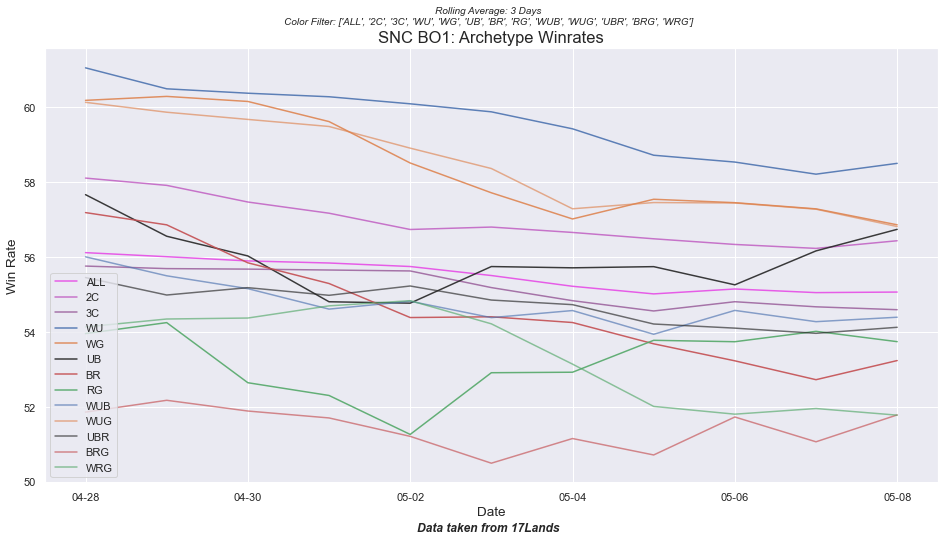

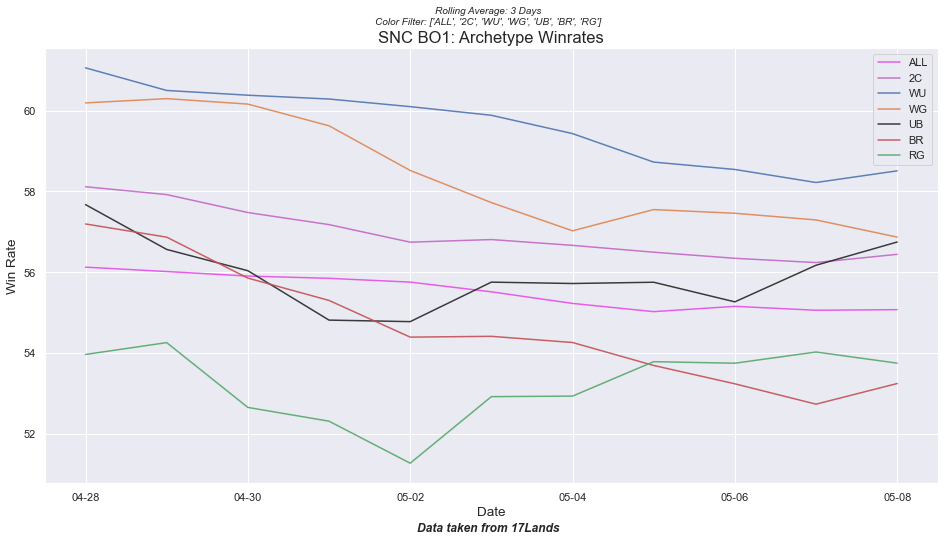

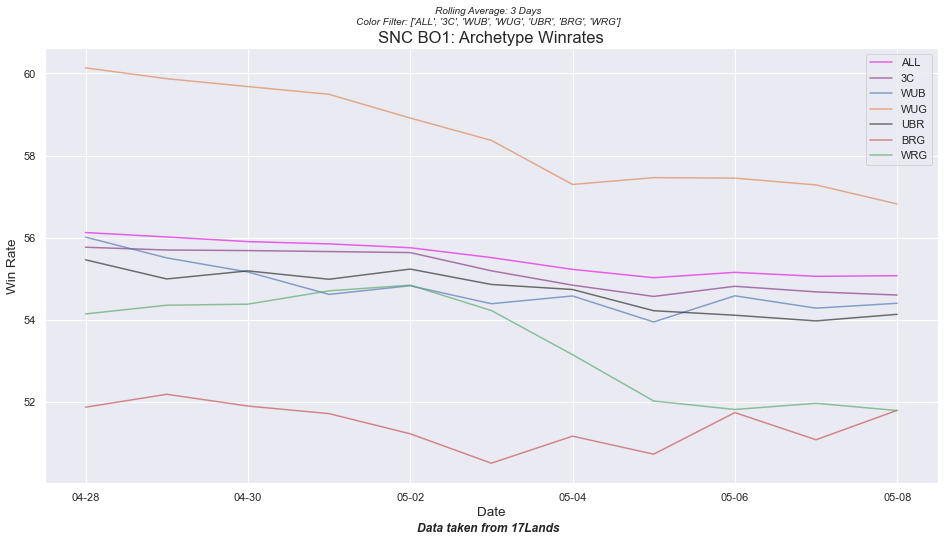

In [21]:
examiner.plot_archetype_winrate_history(['ALL', '2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'])
examiner.plot_archetype_winrate_history(['ALL', '2C', 'WU', 'WG', 'UB', 'BR', 'RG'], pref='2C')
examiner.plot_archetype_winrate_history(['ALL', '3C', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], pref='3C')

## Archetype Playrate History

In [25]:
prettify_frame(examiner.get_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], save=True))

% of Decks,2C,3C,WU,WG,UB,BR,RG,WUB,WUG,UBR,BRG,WRG
Date,,,,,,,,,,,,
2022-04-28,25.23,68.96,4.64,4.19,2.97,9.47,2.98,13.82,16.39,13.03,12.73,12.55
2022-04-29,25.09,69.35,5.46,4.39,2.75,8.53,3.03,13.76,17.65,12.56,12.32,12.66
2022-04-30,25.45,69.17,6.21,4.73,2.74,8.01,2.82,13.95,18.77,12.31,11.59,12.21
2022-05-01,26.67,68.36,7.43,5.26,2.74,7.45,2.87,13.72,20.29,11.76,10.78,11.51
2022-05-02,28.22,67.14,8.60,5.71,3.02,7.28,2.66,13.55,21.09,11.43,9.86,10.94
2022-05-03,29.87,65.81,9.51,6.07,3.27,7.15,2.93,13.16,21.47,11.25,9.22,10.43
2022-05-04,31.13,64.80,10.67,6.22,3.52,6.92,2.82,12.72,21.97,11.17,8.66,10.06
2022-05-05,32.62,63.57,11.40,6.61,3.77,6.96,2.79,12.52,22.84,11.06,7.90,9.02
2022-05-06,33.73,62.73,12.04,7.11,3.89,6.93,2.59,12.11,23.38,10.96,7.43,8.61


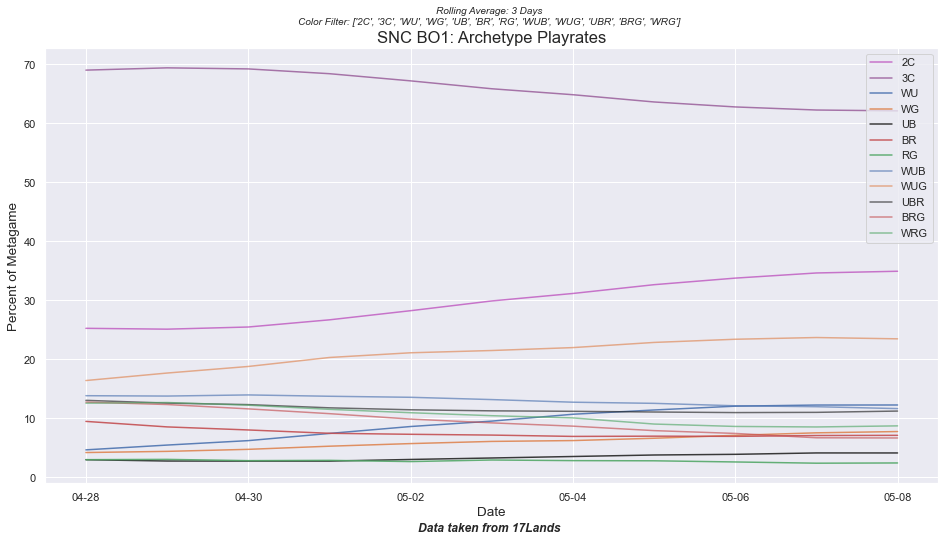

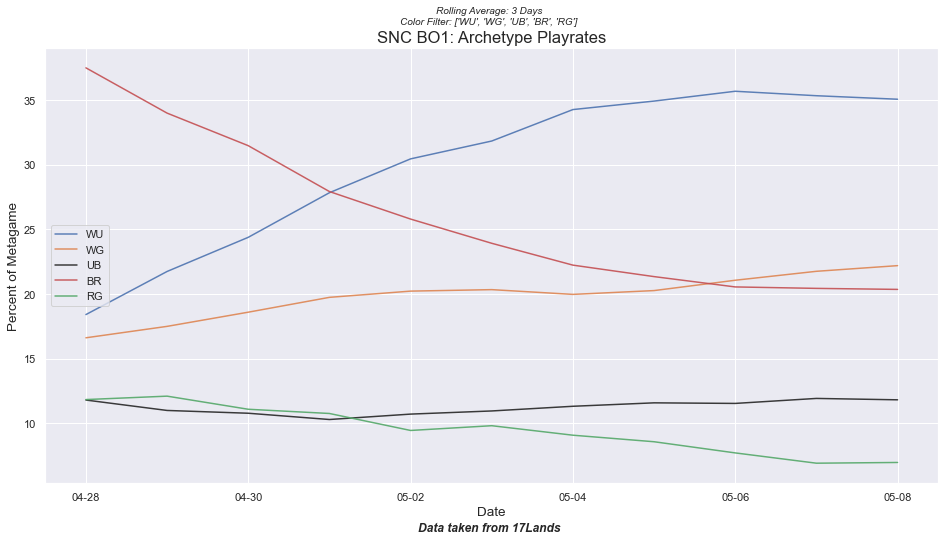

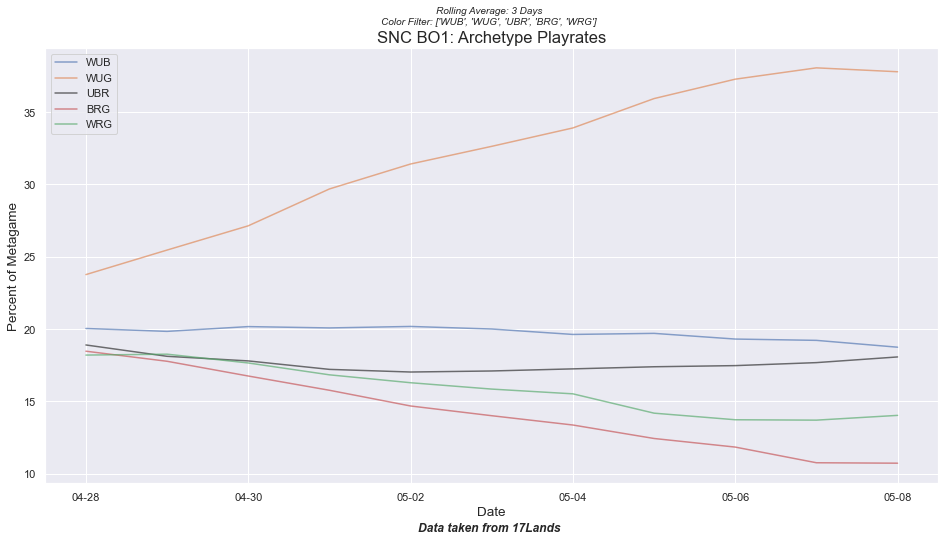

In [24]:
examiner.plot_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'])
examiner.plot_archetype_playrate_history(['WU', 'WG', 'UB', 'BR', 'RG'], 2, pref='2C')
examiner.plot_archetype_playrate_history(['WUB', 'WUG', 'UBR', 'BRG', 'WRG'], 3, pref='3C')

## Achetype Overviews

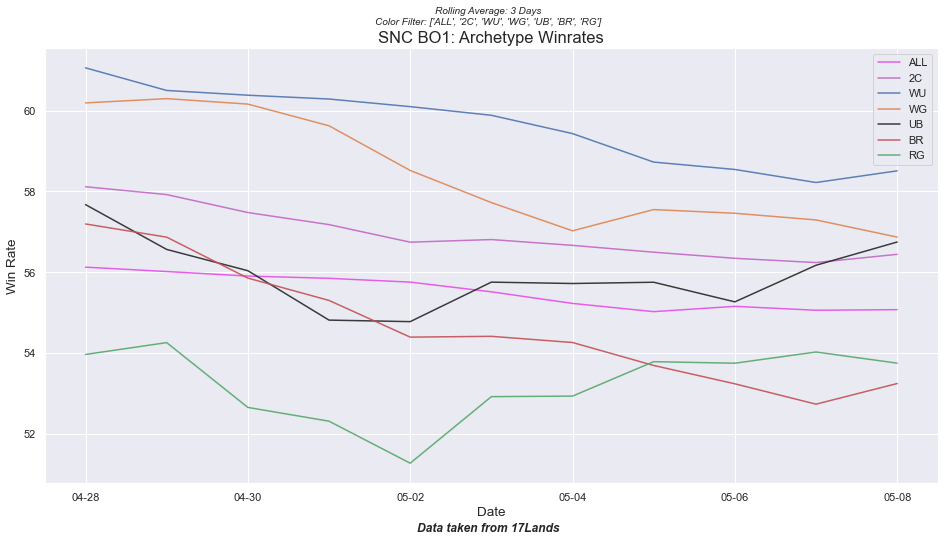

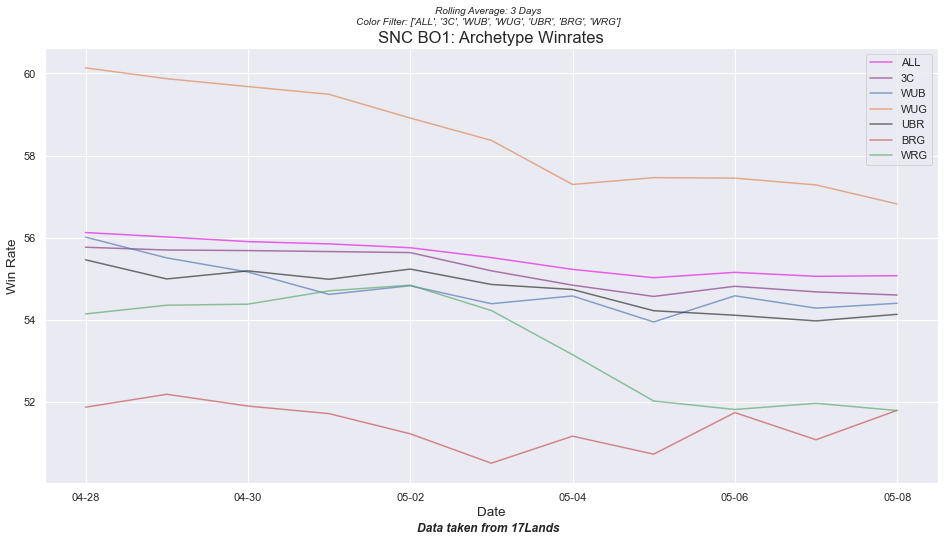

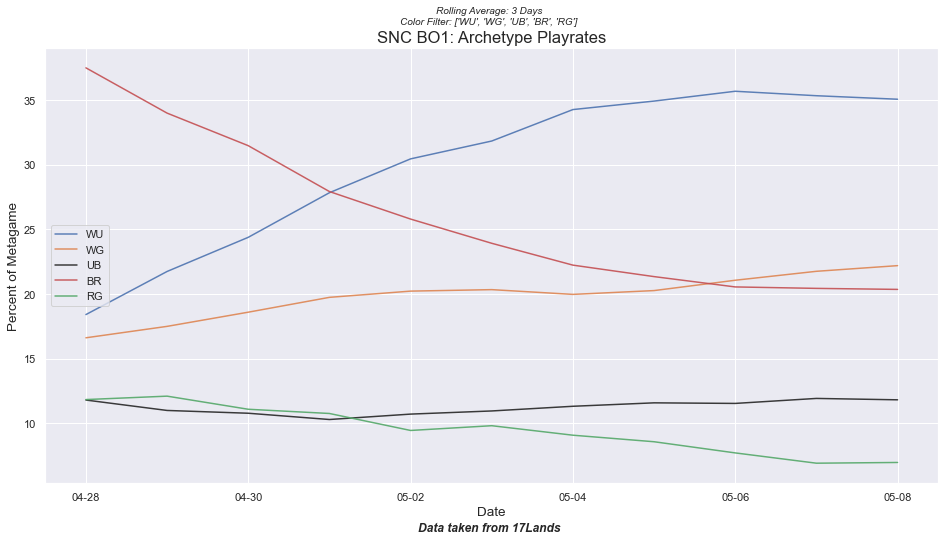

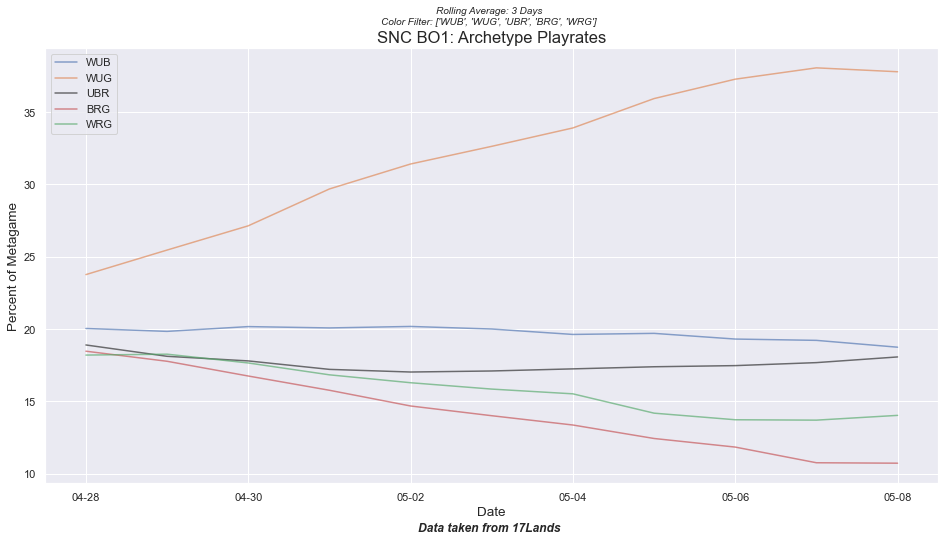

In [12]:
examiner.plot_archetype_winrate_history(['ALL', '2C', 'WU', 'WG', 'UB', 'BR', 'RG'], pref='2C')
examiner.plot_archetype_winrate_history(['ALL', '3C', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], pref='3C')
examiner.plot_archetype_playrate_history(['WU', 'WG', 'UB', 'BR', 'RG'], 2, pref='2C')
examiner.plot_archetype_playrate_history(['WUB', 'WUG', 'UBR', 'BRG', 'WRG'], 3, pref='3C')

## Card Pick Order Changes

In [31]:
#TODO: Merge all of this functionality into one structure.
helper = PlotterHelper(examiner.DATA)
diff = examiner.compare_card_evaluations('2022-04-28', '2022-05-08')
commons = diff[diff['Rarity'] == 'C']
uncommons = diff[diff['Rarity'] == 'U']
SRT_TRG = 'ATA Change'

In [32]:
frame = commons.sort_values(SRT_TRG, ascending=False).head(20)
helper.frame_to_png(frame, "HigherTakenCommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Raffine's Informant,3.60,1.48,4.27,2.54,W,C
Make Disappear,6.69,0.60,8.73,2.11,U,C
Sky Crier,4.95,1.01,6.66,2.10,W,C
Gathering Throng,4.96,1.07,6.25,2.03,W,C
Backup Agent,4.41,0.94,5.78,1.94,W,C
Echo Inspector,3.51,1.19,4.44,1.84,U,C
Quick-Draw Dagger,6.44,1.04,8.79,1.68,,C
Security Bypass,7.25,0.43,10.61,1.50,U,C
Majestic Metamorphosis,6.27,0.96,8.34,1.47,U,C
Spara's Adjudicators,4.74,0.78,6.36,1.45,WUG,C


In [33]:
frame = commons.sort_values(SRT_TRG, ascending=True).head(20)
helper.frame_to_png(frame, "LowerTakenCommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Goldhound,6.47,-0.87,9.49,-1.76,R,C
Big Score,7.15,-0.78,10.82,-1.46,R,C
Jetmir's Fixer,5.73,-0.36,8.50,-1.19,RG,C
Incriminate,8.03,-1.21,12.19,-1.15,B,C
Masked Bandits,5.86,-0.41,8.98,-1.14,BRG,C
Ready to Rumble,7.26,-0.45,11.02,-1.02,R,C
Demon's Due,8.20,-0.75,12.02,-0.99,B,C
Riveteers Overlook,5.57,-0.15,8.14,-0.92,,C
Witty Roastmaster,5.66,-0.09,8.28,-0.89,R,C
Paragon of Modernity,6.66,-0.46,10.12,-0.84,,C


In [34]:
frame = uncommons.sort_values(SRT_TRG, ascending=False).head(10)
helper.frame_to_png(frame, "HigherTakenUncommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Luxurious Libation,3.58,0.75,4.45,1.52,G,U
Hypnotic Grifter,4.11,0.86,5.27,1.49,U,U
Illuminator Virtuoso,3.07,0.79,3.46,1.34,W,U
Out of the Way,3.79,0.85,4.45,1.29,U,U
Psychic Pickpocket,2.65,0.95,3.04,1.27,U,U
Ceremonial Groundbreaker,4.30,0.71,5.58,1.19,WG,U
Take to the Streets,6.15,0.34,8.87,1.11,G,U
Freelance Muscle,2.72,0.56,3.26,1.01,G,U
Exotic Pets,2.79,0.75,3.25,0.94,WU,U
"Lagrella, the Magpie",2.84,0.77,3.19,0.93,WUG,U


In [35]:
frame = uncommons.sort_values(SRT_TRG, ascending=True).head(10)
helper.frame_to_png(frame, "LowerTakenUncommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Riveteers Charm,4.63,-0.77,6.85,-2.37,BRG,U
"Mr. Orfeo, the Boulder",4.28,-0.48,6.22,-2.00,BRG,U
Scuttling Butler,6.29,-0.91,9.89,-1.84,,U
Vampire Scrivener,6.14,-0.67,9.89,-1.64,B,U
Crew Captain,5.49,-0.55,8.79,-1.40,BRG,U
Obscura Charm,4.52,-0.46,6.71,-1.37,WUB,U
Forge Boss,4.44,-0.48,5.88,-1.35,BR,U
Angelic Observer,5.20,-0.41,7.79,-1.26,W,U
Unlucky Witness,5.13,-0.40,7.21,-1.25,R,U
Arc Spitter,7.98,-0.71,12.01,-1.16,,U
